# Lesson 2: use LoFTR for image registration

In this notebook we're going to match each frame of a video with a reference image and we're going to show keypoints found

LoFTR is the state of the art for image registration (ref https://arxiv.org/pdf/2104.00680.pdf)

LoFTR consists of two main components:

### Local Feature Extraction: 
It extracts local features from image patches using a convolutional neural network (CNN). These local features capture distinct patterns and structures within the patches and encode valuable information about the visual content.

### Transformer-based Matching: 
LoFTR utilizes a transformer-based architecture to perform matching between pairs of local features extracted from two images. 

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import random
from pathlib import Path

In [2]:
# import kornia to use LOFTR
import kornia
import kornia as K
import kornia.feature as KF

In [3]:
# Helper functions

%matplotlib inline
def drawMatches(img0, mkpts0, img1, mkpts1, inliers, show_figure=False):
    ''' Draw matches between input image and ref image'''
    w0 = img0.shape[1]
    w1 = img1.shape[1]
    h0 = img0.shape[0]
    h1 = img1.shape[0]
    W = w0 + w1
    H = max(h0, h1)
    dst = np.zeros((H, W, 3)).astype(np.uint8)
    dst[:h0, :w0, :] = img0
    dst[:h1, w0:, :] = img1
    
    for idx, (p0, p1, inlier) in enumerate(zip(mkpts0, mkpts1, inliers)):
        if inlier > 0:
            cv2.line(dst, (int(p0[0]), int(p0[1])), (int(w0 + p1[0]), int(p1[1])), (0,255,0), 1)
            
    for idx, (p0, p1, inlier) in enumerate(zip(mkpts0, mkpts1, inliers)):
        if inlier > 0:
            color = (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
            cv2.circle(dst, (int(p0[0]), int(p0[1])), 5, color, 2)
            cv2.circle(dst, (int(w0 + p1[0]), int(p1[1])), 5, color, 2)

    dst = dst[:,:,::-1]

    if show_figure:
        plt.figure(figsize=(15,10))
        plt.imshow(dst)
        plt.show()
    return dst

In [4]:
def match_loftr(img0, img1, matcher, device, nb_matches = 3000):
    ''' Match two images with LoFTR'''
    img0, org_w0, org_h0 = load_torch_image(img0, device=device, longest_imgsize=840, padding=True)
    img1, org_w1, org_h1 = load_torch_image(img1, device=device, longest_imgsize=840, padding=True)

    input_dict = {"image0": K.color.rgb_to_grayscale(img0), 
                  "image1": K.color.rgb_to_grayscale(img1)}
   
    with torch.inference_mode():
        correspondences = matcher(input_dict)

    conf = correspondences['confidence'].cpu().numpy()
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    
    sorted_idx = np.argsort(-conf)
    if len(conf) > nb_matches:
        mkpts0 = mkpts0[sorted_idx[:nb_matches], :]
        mkpts1 = mkpts1[sorted_idx[:nb_matches], :]
    
    mkpts0[:,0] = mkpts0[:,0] * org_w0 / img0.shape[3]
    mkpts0[:,1] = mkpts0[:,1] * org_h0 / img0.shape[2]
    
    mkpts1[:,0] = mkpts1[:,0] * org_w1 / img1.shape[3]
    mkpts1[:,1] = mkpts1[:,1] * org_h1 / img1.shape[2]

    return mkpts0, mkpts1

def load_torch_image(img, device, longest_imgsize, padding=False):
    ''' Reshape image to a specific size '''
    org_w = img.shape[1]
    org_h = img.shape[0]
    scale = longest_imgsize / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    if padding:
        org_w = max(org_w, org_h)
        org_h = max(org_w, org_h)
        base = np.zeros((longest_imgsize, longest_imgsize, 3)).astype(np.uint8)
        base[:img.shape[0], :img.shape[1], :] = img
        img = base
    img = K.image_to_tensor(img, False).float() / 255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device), org_w, org_h

In [5]:
# read the image on the disk
source_path = Path().absolute().parent

In [6]:
# define input image path and video path
image_path = os.path.join(source_path, 'Data', 'registration.jpg')
video_path = os.path.join(source_path, 'Data', 'registration_video.mkv')

In [7]:
ref_image = cv2.imread(image_path)

In [8]:
# resize image
factor = 0.4
height, width = ref_image.shape[:2]
new_width = int(width * factor)
new_height = int(height * factor)
ref_image = cv2.resize(ref_image, (new_width, new_height))

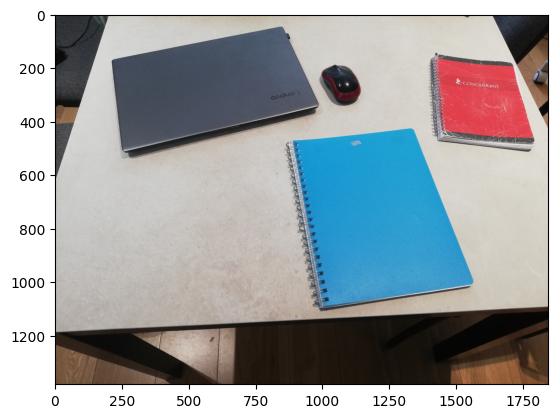

In [9]:
rgb_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB) 
plt.imshow(rgb_image)

In [10]:
# set device, use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# instantiate the LoFTR registrator
matcher = KF.LoFTR()
matcher = matcher.to(device).eval()

In [12]:
# read video
cap = cv2.VideoCapture(video_path)


print("start")
count = 0
# Check if the directory exists
directory = os.path.join(source_path, 'Data', 'registered')
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)
    
while cap.isOpened():
    print("Processing frame {}".format(count))
    ret, frame = cap.read()
    if not ret:
        break
        
    # Perform operations on the frame
    mkpts0, mkpts1 = match_loftr(frame, ref_image, matcher, device)
    H, inliers = cv2.findHomography(mkpts0, mkpts1, method=cv2.RANSAC)
    dst = drawMatches(frame, mkpts0, ref_image, mkpts1, inliers)

    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB) 
    cv2.imwrite(os.path.join(directory, f'{count}.jpg'), dst)
    
    count = count + 1
    
cap.release()

start
Processing frame 0
Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Processing frame 48
Processing frame 49
Proc

In [13]:
def generate_video_from_frames(frames_folder, output_video_path, fps=24.0):
    ''' function used to generate a video from a folder containing frames'''
    image_files = sorted([int(f.split('.')[0]) for f in os.listdir(frames_folder) if f.endswith(".jpg")])
    image_path = os.path.join(frames_folder, str(image_files[0]) + '.jpg')
    frame = cv2.imread(image_path)
    height, width, _ = frame.shape

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Use "XVID" codec for AVI format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image_file in image_files:
        image_path = os.path.join(frames_folder, str(image_file) + '.jpg')
        frame = cv2.imread(image_path)

        # Write the frame to the video
        video_writer.write(frame)

    # Release the VideoWriter object
    video_writer.release()

In [14]:
''' Generate output video '''
frames_folder_path = directory
output_video_path = os.path.join(source_path, 'Data', 'outvideo_video.avi')
generate_video_from_frames(frames_folder_path, output_video_path)

Let's display only one frame

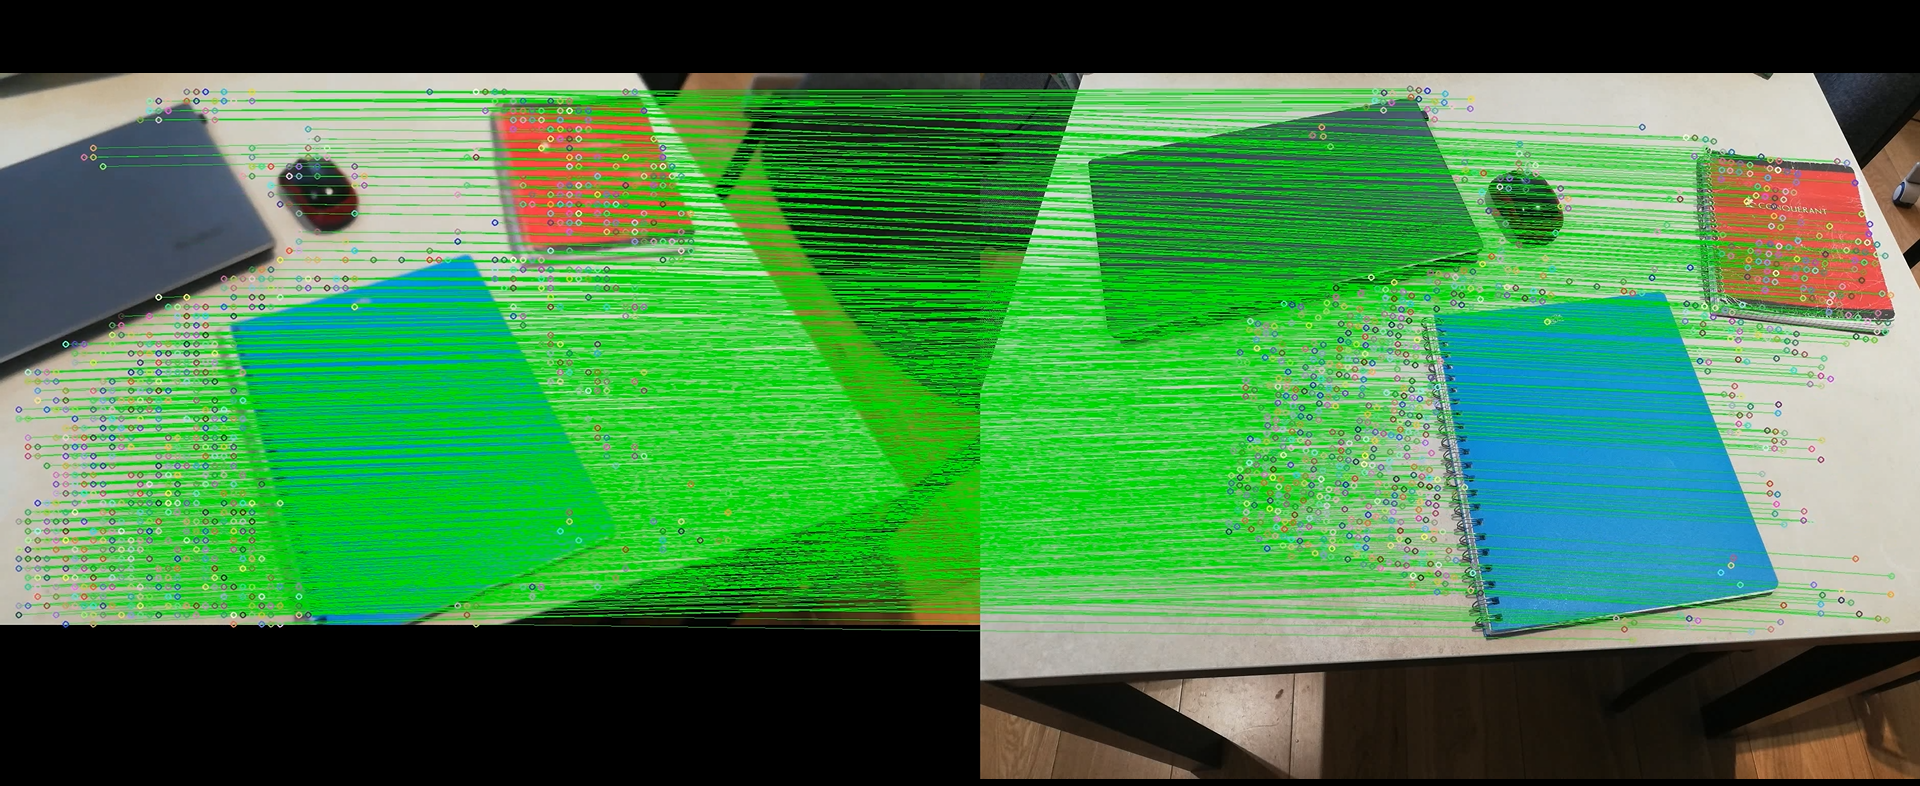